In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Load dataset
# Replace 'us_election_dataset.csv' with your actual dataset file
data = pd.read_csv('/content/USElectionHateSpeech - Aug_chunk1.csv')

In [ ]:
# Preprocessing
data['text'] = data['text'].str.lower().str.replace('[^\w\s]', '')  # Lowercase and remove punctuation
data = data.dropna(subset=['text', 'Hate'])  # Drop rows with missing text or labels

# Encode labels
label_encoder = LabelEncoder()
data['Hate'] = label_encoder.fit_transform(data['Hate'])

# Check the number of unique classes
num_classes = data['Hate'].nunique()
print(f"Number of classes: {num_classes}")

Number of classes: 3


<ipython-input-11-655d4af20ce3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Hate'] = label_encoder.fit_transform(data['Hate'])


In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
word_index = tokenizer.word_index

# Padding sequences
data_padded = pad_sequences(sequences, maxlen=100)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(data_padded, data['Hate'], test_size=0.2, random_state=42)

# One-hot encode labels for multi-class classification
if num_classes > 2:
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_test = to_categorical(y_test, num_classes=num_classes)

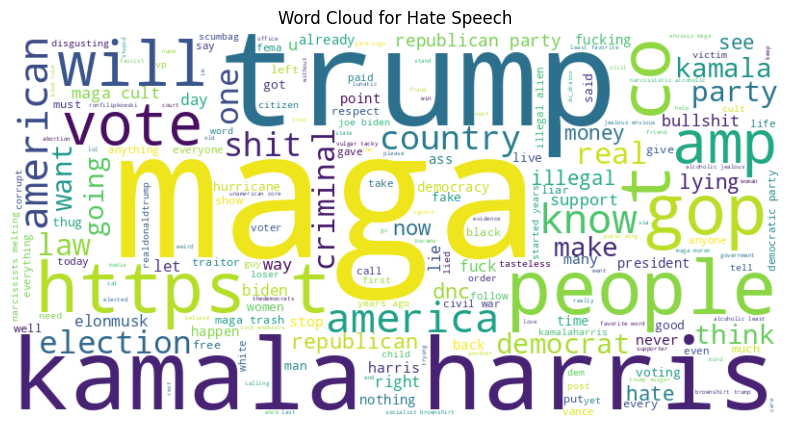

In [ ]:
# Word Cloud for Hate Speech
hate_text = " ".join(data[data['Hate'] == 1]['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(hate_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Hate Speech")
plt.show()

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 347ms/step - accuracy: 0.5938 - loss: 0.9941 - val_accuracy: 0.7375 - val_loss: 0.6252
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 381ms/step - accuracy: 0.6687 - loss: 0.6424 - val_accuracy: 0.7375 - val_loss: 0.5714
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step - accuracy: 0.6905 - loss: 0.6184 - val_accuracy: 0.7375 - val_loss: 0.5667
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.6937 - loss: 0.5999 - val_accuracy: 0.7375 - val_loss: 0.5571
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 320ms/step - accuracy: 0.7046 - loss: 0.5342 - val_accuracy: 0.7500 - val_loss: 0.5645
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.87      0.77       126
           1       0.60      0.32      0.42        74

    accuracy                           0.67       200
   macro avg       0.64      0.60      0.60       200
weighted avg       0.66      0.67    

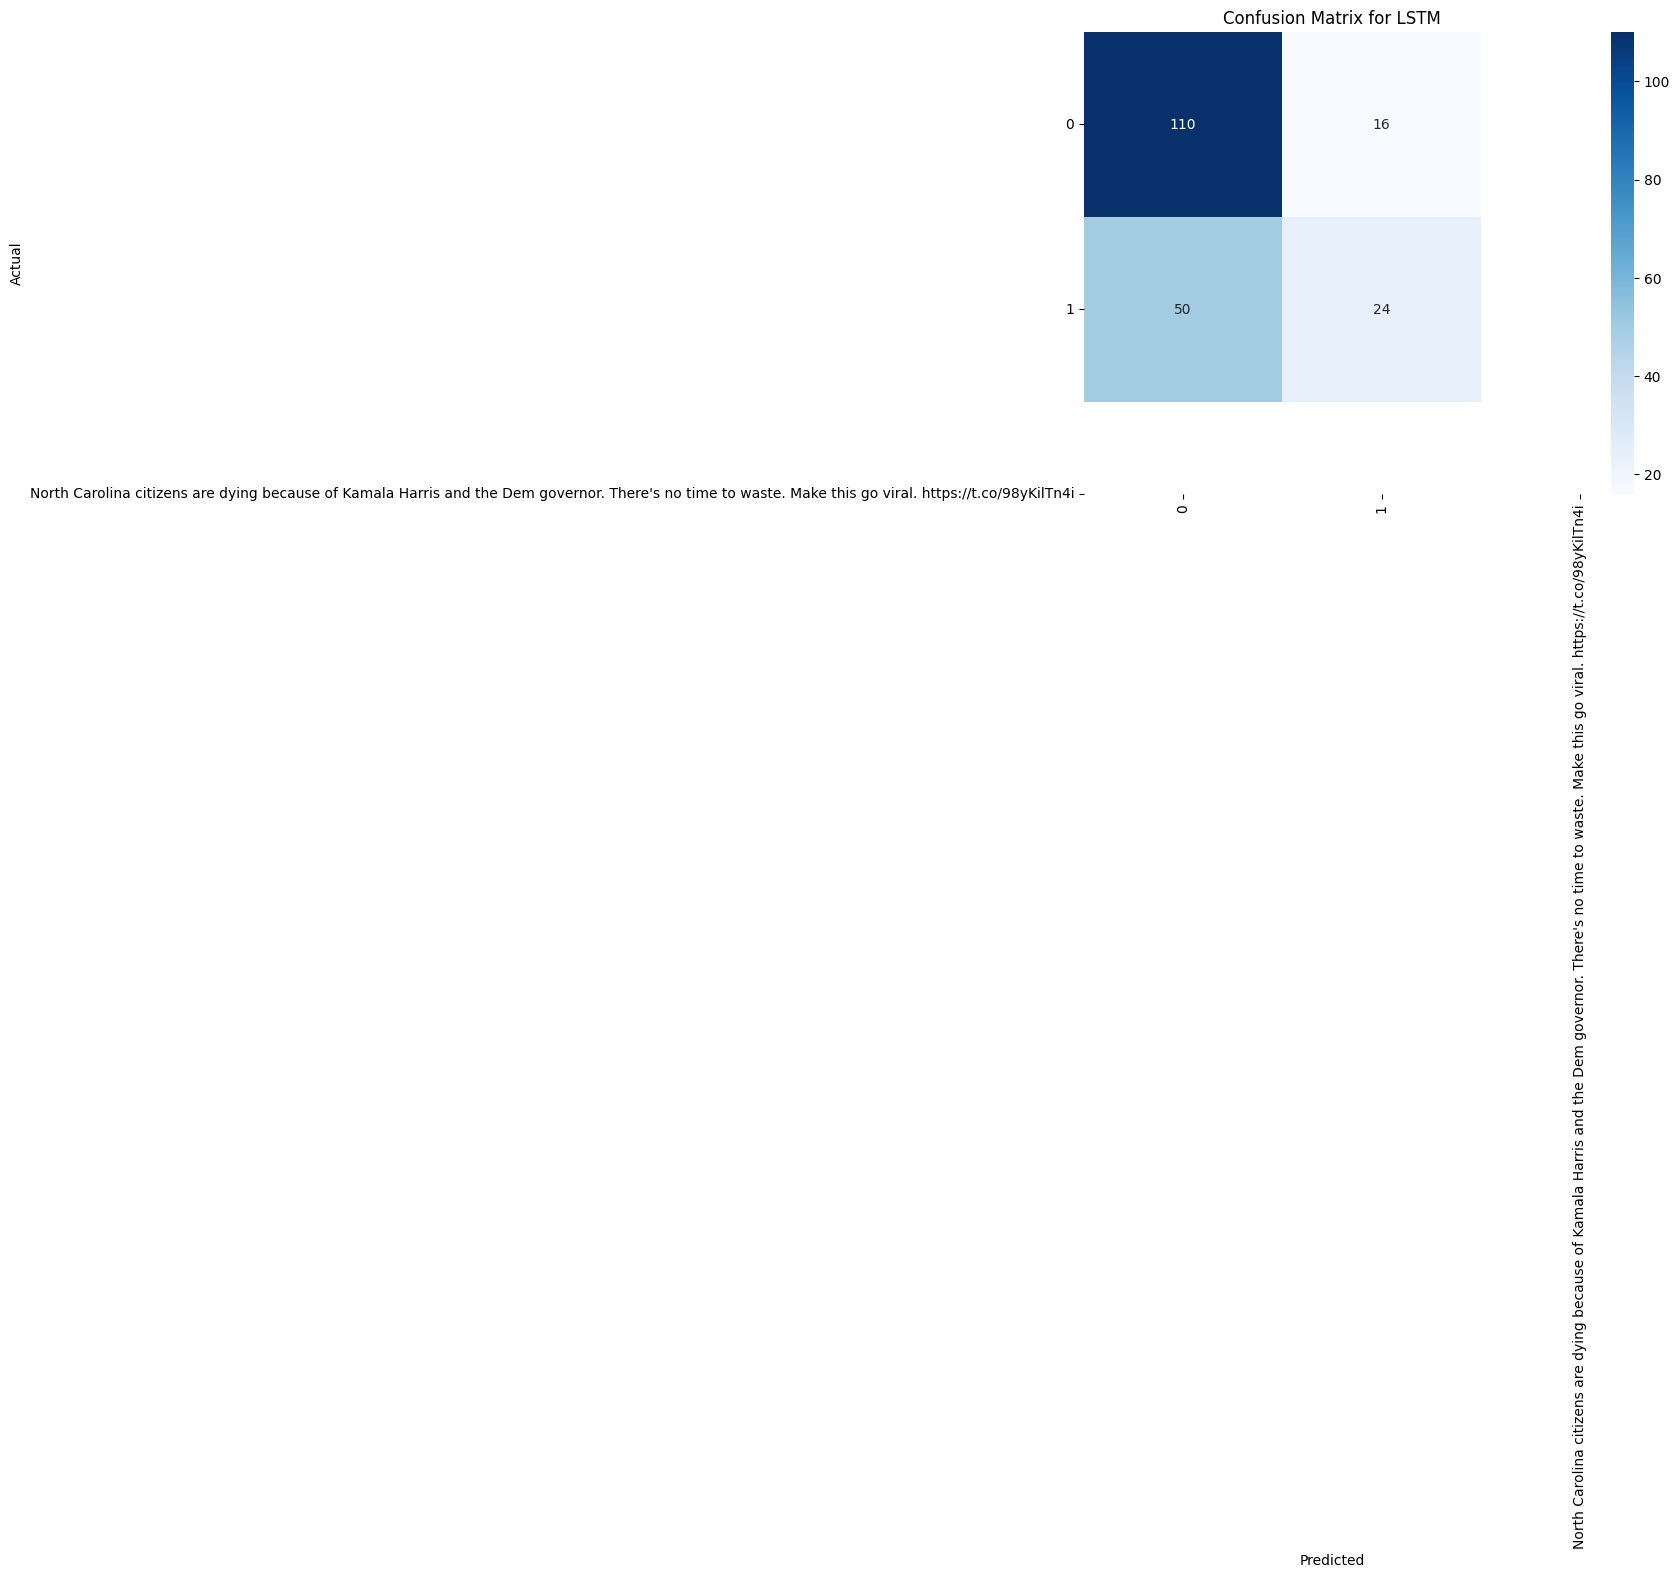

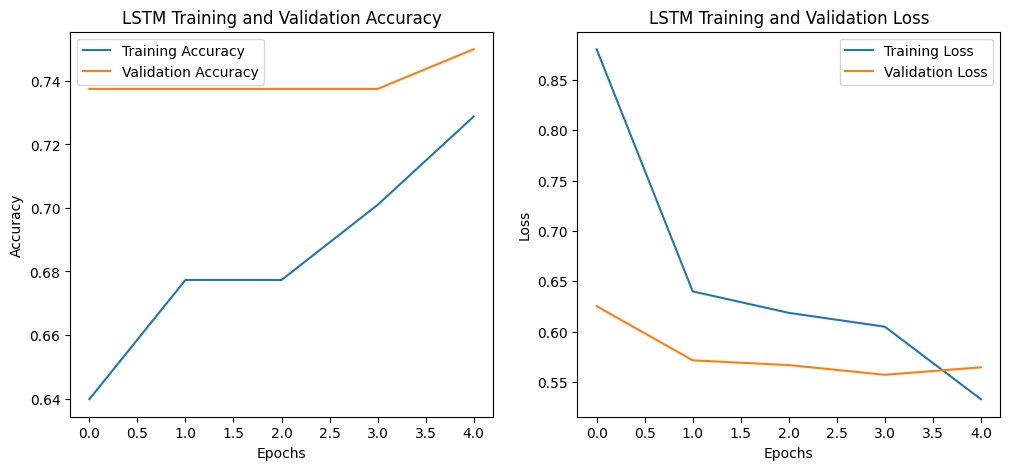

In [ ]:
# LSTM Model
model_lstm = Sequential()
model_lstm.add(Embedding(10000, 128, input_length=100))
model_lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
if num_classes > 2:
    model_lstm.add(Dense(num_classes, activation='softmax'))  # Multi-class output
    model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
    model_lstm.add(Dense(1, activation='sigmoid'))  # Binary output
    model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train LSTM
history_lstm = model_lstm.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

# Evaluate LSTM
y_pred_lstm = model_lstm.predict(X_test)
if num_classes > 2:
    y_pred_lstm = np.argmax(y_pred_lstm, axis=1)  # Convert probabilities to class labels
    y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels back to class labels
else:
    y_pred_lstm = np.round(y_pred_lstm).astype(int)  # Binary classification

print("LSTM Classification Report:")
print(classification_report(y_test_labels if num_classes > 2 else y_test, y_pred_lstm))

# Confusion Matrix for LSTM
cm_lstm = confusion_matrix(y_test_labels if num_classes > 2 else y_test, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot Training and Validation Accuracy/Loss for LSTM
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 313ms/step - accuracy: 0.5802 - loss: 1.0456 - val_accuracy: 0.7375 - val_loss: 0.7165
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - accuracy: 0.7029 - loss: 0.6858 - val_accuracy: 0.7375 - val_loss: 0.6262
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step - accuracy: 0.6721 - loss: 0.6248 - val_accuracy: 0.7375 - val_loss: 0.5431
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - accuracy: 0.7058 - loss: 0.5471 - val_accuracy: 0.7500 - val_loss: 0.5314
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - accuracy: 0.8133 - loss: 0.4272 - val_accuracy: 0.7500 - val_loss: 0.5357
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
GRU Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.88      0.76       126
           1       0.57      0.27      0.37        74

    accuracy                           0.66       200
   macro avg       0.62      0.58      0.56       200
weighted avg       0.64      0.66     

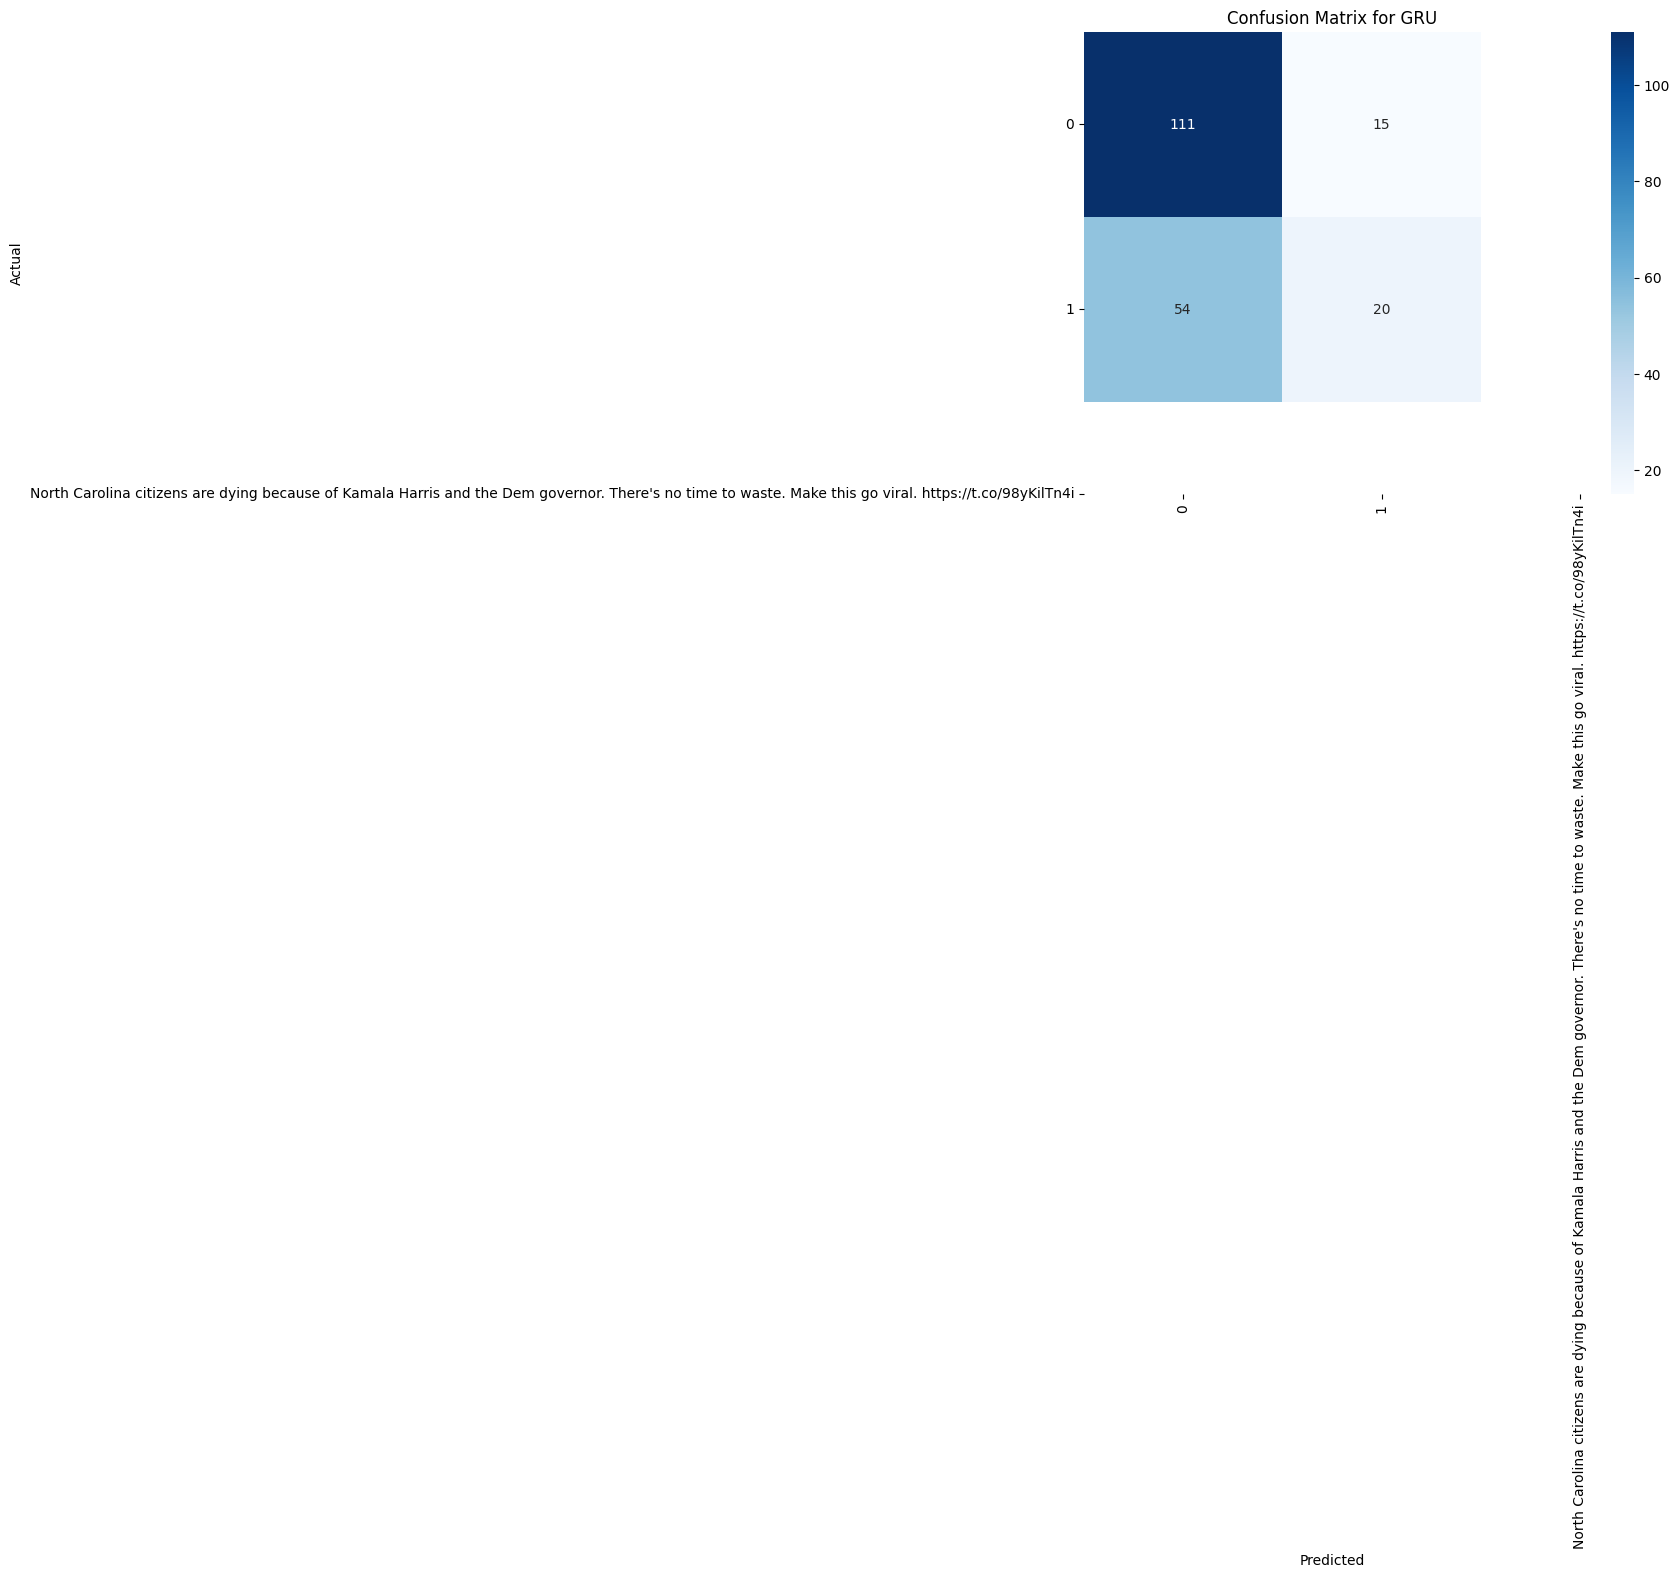

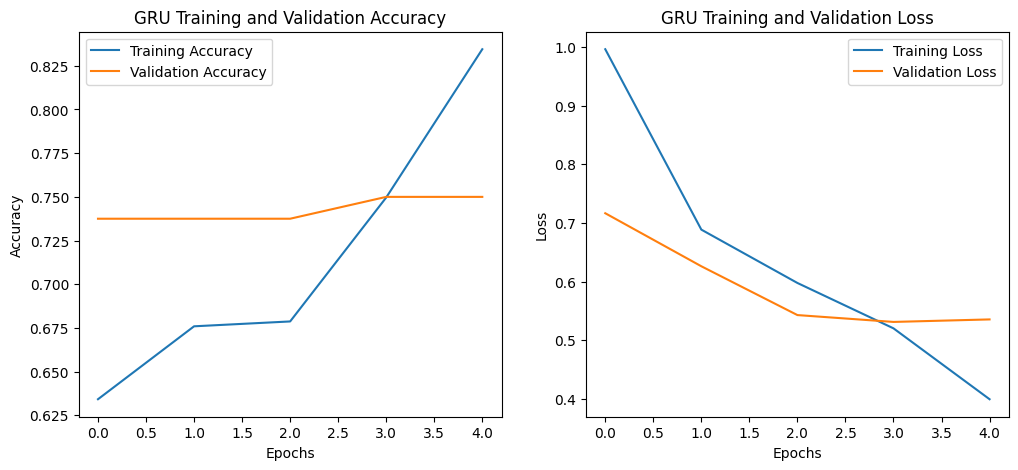

In [ ]:
# GRU Model
model_gru = Sequential()
model_gru.add(Embedding(10000, 128, input_length=100))
model_gru.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
if num_classes > 2:
    model_gru.add(Dense(num_classes, activation='softmax'))  # Multi-class output
    model_gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
    model_gru.add(Dense(1, activation='sigmoid'))  # Binary output
    model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train GRU
history_gru = model_gru.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

# Evaluate GRU
y_pred_gru = model_gru.predict(X_test)
if num_classes > 2:
    y_pred_gru = np.argmax(y_pred_gru, axis=1)
else:
    y_pred_gru = np.round(y_pred_gru).astype(int)

print("GRU Classification Report:")
print(classification_report(y_test_labels if num_classes > 2 else y_test, y_pred_gru))

# Confusion Matrix for GRU
cm_gru = confusion_matrix(y_test_labels if num_classes > 2 else y_test, y_pred_gru)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for GRU")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot Training and Validation Accuracy/Loss for GRU
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_gru.history['accuracy'], label='Training Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('GRU Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [5]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

In [8]:
# Ensure Transformers uses PyTorch instead of TensorFlow
os.environ["TRANSFORMERS_NO_TF"] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
df = pd.read_csv("/content/USElectionHateSpeech - Aug_chunk1.csv")

# Ensure labels are integers
df["Hate"] = pd.to_numeric(df["Hate"], errors="coerce")
df = df.dropna(subset=["Hate"])  # Drop rows where 'hate' could not be converted
df["Hate"] = df["Hate"].astype(int)  # Convert to integer

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", use_fast=False)

# Custom Dataset Class
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(self.texts[idx], padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        return {"input_ids": encoding["input_ids"].squeeze(),
                "attention_mask": encoding["attention_mask"].squeeze(),
                "labels": torch.tensor(int(self.labels[idx]), dtype=torch.long)}

# Split dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(df["text"].tolist(), df["Hate"].tolist(), test_size=0.2, random_state=42)
train_dataset = HateSpeechDataset(train_texts, train_labels)
val_dataset = HateSpeechDataset(val_texts, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Load BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, no_deprecation_warning=True)

# Training Loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=total_loss/len(train_loader))

print("Training complete!")

# Save model
model.save_pretrained("hate_speech_bert_model")
tokenizer.save_pretrained("hate_speech_bert_model")

# Evaluation
def evaluate(model, dataloader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
    return accuracy_score(true_labels, predictions), classification_report(true_labels, predictions)

accuracy, report = evaluate(model, val_loader)
print(f"Validation Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 3: 100%|██████████| 50/50 [17:03<00:00, 20.47s/it, loss=0.27]


Training complete!
Validation Accuracy: 0.7800
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.80      0.83       132
           1       0.66      0.74      0.69        68

    accuracy                           0.78       200
   macro avg       0.76      0.77      0.76       200
weighted avg       0.79      0.78      0.78       200

